<div style="background-color:rgba(0, 167, 255, 0.6);border-radius:5px;display:fill">
    <h1><center>Tabular Playground Series - March 2022</center></h1>
</div>

We need to forecast twelve-hours of traffic flow in a major U.S. metropolitan area. Time, space, and directional features are given and our job is to model the congestion of the future timesteps. 

As @ambros mentioned in his notebook, most of the notebooks are applying one or more ofthe following concepts

* Predict test congestions using an ensemble of gradient-boosted trees

* Replace some predictions by so-called "special values" 

* Round the predictions to the nearest integer 

The core of this TPS playground series to play with various new techniques and observe. Here I will present two different ways to approaches to handle it.


<div class="alert alert-block alert-info"> 📌 Here I will also show how simple six lines code can be used to get indepth analysis of the data and trained model.</div>





## <span style="color:crimson;"> DONT FORGET TO UPVOTE IF YOU FIND IT USEFUL.......!!!!!! </span>



## <font color="#blue">This Notebook consists of two parts.</font>


# PART ONE : Treating data in pandas dataframe format
### <a href='#1'>1. Introduction </a><br>
### <a href='#2'>2. Importing Libraries and Data</a><br>
### <a href='#3'>3. Feature Engineering</a><br>
### <a href='#4'>4. Training and forecasting</a><br>
### <a href='#5'>5. Quality check of model -The magic</a><br>
### <a href='#6'>6. Postprocessing for Submission </a><br>
# PART TWO : Treating data in timeseries data structure format
### <a href='#7'>1. Introduction</a><br>
### <a href='#8'>2. Importing Libraries and Data</a><br>
### <a href='#9'>3. Feature Engineering</a><br>
### <a href='#10'>4. Neural Basis Expansion Analysis</a><br>
### <a href='#11'>5. Quality check of model (work in progress )</a><br>
### <a href='#12'>6. Blending of both approaches (work in progress )</a><br>

<a id="1"></a><h2></h2>
<div style="background-color:rgba(255, 169, 0, 0.5);border-radius:10px;display:fill">
    <h1><center>Part one- Treating data in pandas dataframe format </center></h1>
</div>
<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Introduction</center></h1>
</div>

The first of part of notebook is highly inspired from notebooks of @KOTRYING and @ambrosm. Please don't forget to upvote their notebooks.

<img src="https://www.myimprov.com/wp-content/uploads/2016/05/NEWtraffic-jam-sir-funny-jokes.jpg" alt="alternatetext">



****

<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Importing Libraries</center></h1>
</div>
<a id="2"></a><h2></h2>

In [ ]:
%%capture
!pip install pycaret[full]
import pandas as pd
import numpy as np 
from pycaret.regression import *
import warnings
warnings.filterwarnings("ignore")

<a id="3"></a><h2></h2>
<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Loading data and feature engineering</center></h1>
</div>

In [ ]:
# few modifications to https://www.kaggle.com/code/kotrying/tps-2022-03-lgbm
train = pd.read_csv('../input/tabular-playground-series-mar-2022/train.csv',index_col='row_id')
test = pd.read_csv('../input/tabular-playground-series-mar-2022/test.csv',index_col='row_id')
train['time'] = pd.to_datetime(train.time)
# delete official holiday                                                 
train['offical_holiday'] = train.time.dt.date.astype(str).str.contains('1991-05-27|1991-07-04|1991-09-02').astype('int')
train=train[train['offical_holiday']==0]
train=train.drop('offical_holiday',axis=1)
# train on data for Mondays to Thursdays and complete months only
train=train[(train.time.dt.weekday< 4) & (train.time.dt.month > 4)]  

In [ ]:
def pre_process(df): 
    df['time'] = pd.to_datetime(df['time'])
    df['month']= df.time.dt.month
    df['day']= df.time.dt.dayofyear
    df['am'] = (df.time.dt.hour < 12) & (df.time.dt.hour >6)
    df['wkday'] = df.time.dt.weekday
    df['time']= (df.time.dt.hour-12)*3+df.time.dt.minute/20
    df['xydirday']= df.x.astype(str)+df.y.astype(str)+df.direction+df.day.astype(str)
    df['xydir'] = df.x.astype(str)+df.y.astype(str)+df.direction
    df['all']= df['xydir']+df.time.astype(str)
pre_process(train)
pre_process(test)
# calculate average traffic flow for each time of day 
mapper_avg = train[['all','congestion']].groupby(['all']).median().to_dict()['congestion']

In [ ]:
train['avg']= train['all'].map(mapper_avg)
test['avg']= test['all'].map(mapper_avg)
train= train[train.time >=0]
display(train.head(2),test.head(2))

<a id="4"></a><h2></h2>
<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Training and forecasting</center></h1>
</div>

In [ ]:
# few modifications to https://www.kaggle.com/code/kotrying/tps-2022-03-lgbm
reg = setup(data = train,
            target = 'congestion',
            session_id=999,
            data_split_shuffle = True, 
            create_clusters = False,
            fold_strategy = 'groupkfold',
            fold_groups = 'xydir',
            use_gpu = False,
            silent = True,
            pca = True, 
            pca_components = 2,
            fold=10,
            ignore_features = ['all','day','xydirday'],
            n_jobs = -1)

In [ ]:
top3 = compare_models(sort = 'MAE', n_select=3, exclude = ['lar',  'rf', 'et', 'gbr', 'xgboost'])

In [ ]:
blender = blend_models(top3)

In [ ]:
final = finalize_model(blender)

In [ ]:
test['pred'] = (predict_model(final, data=test)['Label']).round()

# Idea from https://www.kaggle.com/code/ambrosm/tpsmar22-generalizing-the-special-values
sep = train[(train.day >= 246) & (train.time >= 0)]
lower = sep.groupby(['time', 'x', 'y', 'direction']).congestion.quantile(0.15).values
upper = sep.groupby(['time', 'x', 'y', 'direction']).congestion.quantile(0.7).values
test.pred = test.pred.clip(lower, upper)
# for roadways with low value count replace prediction with nearest value from the training data
for xydir in set(test.xydir):
    
    xydir_counts = train.loc[train.xydir ==xydir,'congestion'].value_counts()
    
    l = xydir_counts[(xydir_counts > 200)] # experimental
    if len(l) > 2: # experimental
        l = list(l.index)
        test.loc[test.xydir ==xydir,'pred']= test.loc[test.xydir ==xydir,'pred'].map(lambda y: min(l, key=lambda x:abs(x-y)))
test.rename(columns = {'pred':'congestion'}, inplace = True)

<a id="5"></a><h2></h2>
<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>QC of the data and model </center></h1>
</div>

Here we will utilize DeepChecks to validate your machine learning models and data, such as verifying your data’s integrity, inspecting its distributions, validating data splits, evaluating the model. Interestingly it will take only seven lines of code to do that.




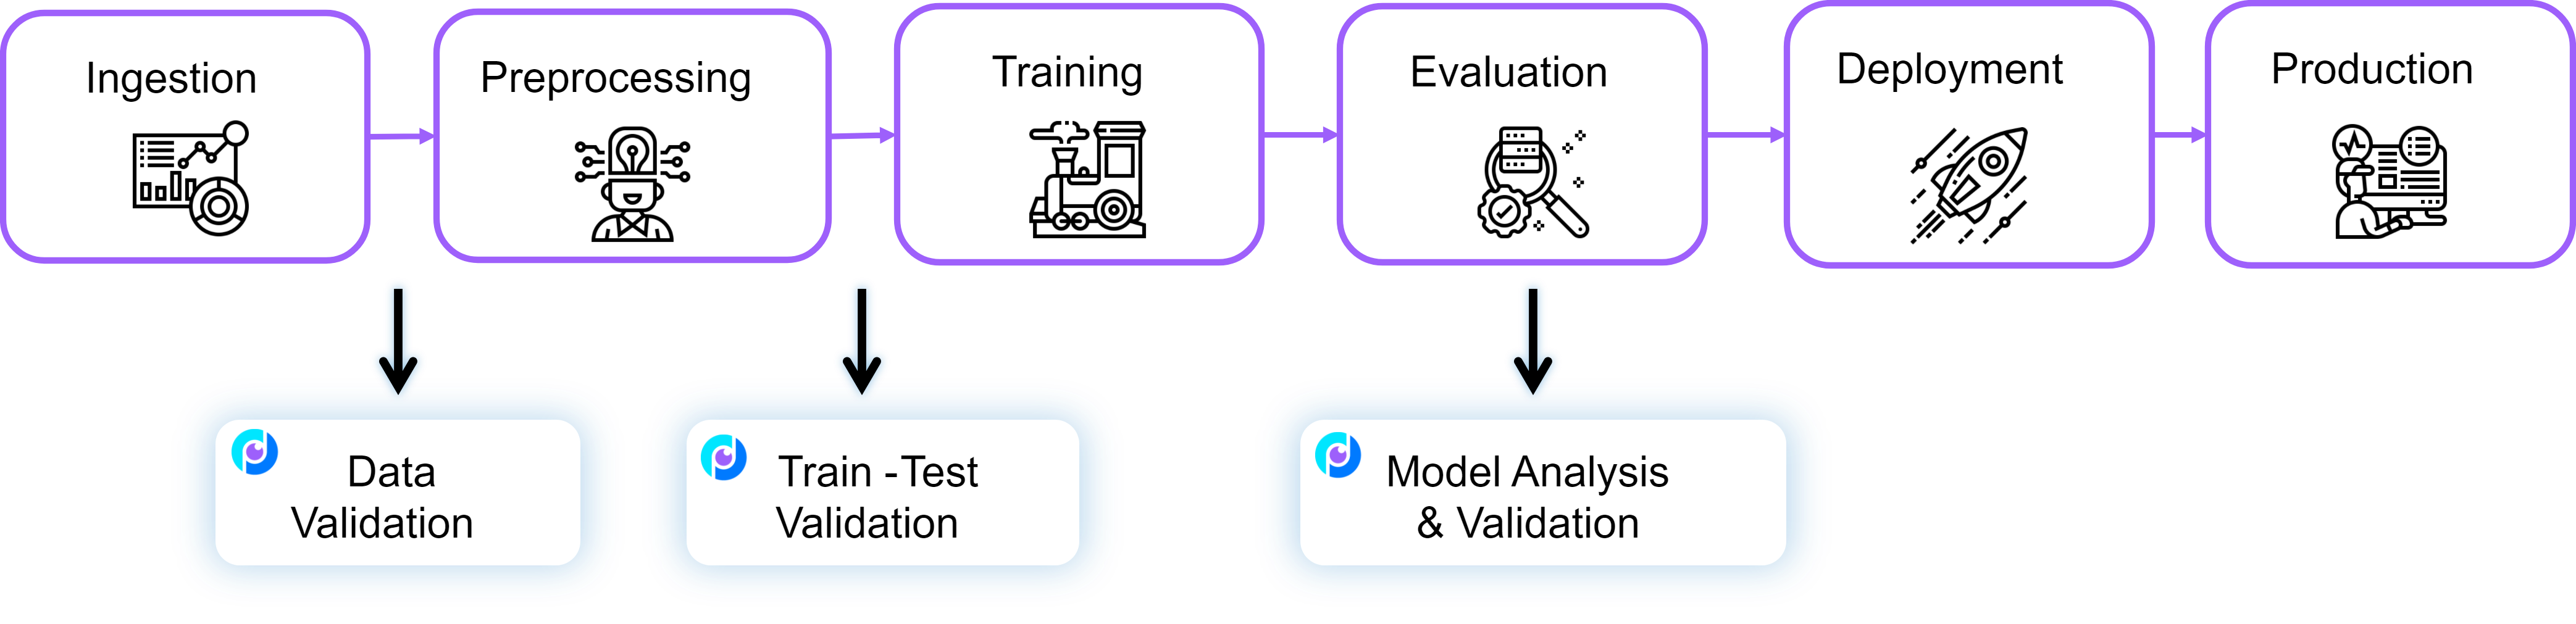

In [ ]:
!pip install deepchecks --user
from deepchecks.suites import full_suite
from deepchecks.base import Dataset

In [ ]:
# Now the magic......
train_dataset = Dataset(train, label='congestion', cat_features=['xydirday','xydir','all'])
test_dataset = Dataset(test, label='congestion', cat_features=['xydirday','xydir','all'])
suite = full_suite()
suite.run(train_dataset=train_dataset, test_dataset=test_dataset, model=final)

<a id="6"></a><h2></h2>
<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Postprocessing for Submission</center></h1>
</div>

In [ ]:
sub = pd.DataFrame(list(zip(test.index,test.congestion.values)),columns = ['row_id', 'congestion'])
sub.to_csv('submission.csv', index = False)
sub.head()

<div class="alert alert-block alert-info"> 📌 For some reason there is an issue in installing libraries, we need to apply factory reset and run part one and part two seperately, I am still looking for a solution to run both of them together. 
    As a temperory solution, the results of the second part will be presented as screenshot. If you know how to solve it, please inform me in the comments section.¶
add Codeadd Markdown
PART TWO : Treating data in timeseries data structure format.</div>

<div style="background-color:rgba(255, 169, 0, 0.5);border-radius:10px;display:fill">
    <h1><center>PART TWO : Treating data in timeseries data structure format </center></h1>
</div>
<a id="7"></a><h2></h2>
<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Introduction</center></h1>
</div>

In the second part of notebook, I want to try something new instead of traditional gradient boosting/ tree based techniques. Please find another unique approach that I have shared the following <a href="https://www.kaggle.com/code/abdulravoofshaik/google-s-temporal-fusion-transformers/edit/run/89911411">link</a>.


Although deep learning is being used for time series prediction, this is often done with statistical-based models. However, the N-BEATS <a href="https://arxiv.org/pdf/1905.10437.pdf">paper</a> showed results that finally surpassed the performance of statistical-based models and hybrid models (statistics + deep learning) in existing time series prediction competitions using only deep learning. It outperforms well-established statistical approaches on the M3, and M4 competitions.  

The Basic idea of Time Series modeling with Deep learning is to re-arrange the data into windows of sequences, and labels.

<img src="https://bulatov.page/static/bdd8dcbea3f7d4b56ccb460f0323af52/1ed31/ml_model.png" alt="alternatetext">

<a id="8"></a><h2></h2>
<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Importing Libraries</center></h1>
</div>

In [ ]:

import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from matplotlib_venn import venn2_unweighted   
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [ ]:
os.chdir("../../..")
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
!pip install pytorch-forecasting   
import pytorch_lightning as pl
!pip install darts
from darts import TimeSeries
from darts.models import ExponentialSmoothing

In [ ]:
from darts import TimeSeries
from darts.models import ExponentialSmoothing

<a id="9"></a><h2></h2>
<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Loading data and feature engineering</center></h1>
</div>

In [ ]:
#include missng values
train = pd.read_csv('kaggle/input/tabular-playground-series-mar-2022/train.csv')
train.time = pd.to_datetime(train.time,format='%Y/%m/%d %H:%M:%S')  
train['time_id'] = ( ( (train.time.dt.dayofyear-1)*24*60 + train.time.dt.hour*60 + train.time.dt.minute ) /20 ).astype(int)
#train = train.set_index('row_id', drop=True)
train['dir']=train['direction'].astype(str) +'_' +train['x'].astype(str)+'_' +train['y'].astype(str)
train['dir_time']=train['dir'].astype(str) +'_' +train['time_id'].astype(str)
train.head()

In [ ]:
#now we need to include the congestion data
unique_loca=train.dir.unique().tolist()
len(unique_loca)

<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Missing Values</center></h1>
</div>

In [ ]:
# feature engineering to fix the missing values
train_fulldata1 = pd.DataFrame(pd.date_range('1991-04-01 00:00:00', '1991-09-30 11:40:00', freq='20Min'), columns=['time'])
train_fulldata1.describe()

In [ ]:
#adding direction information to timeseries
train_df_fulldata2 = pd.merge( pd.DataFrame(train['dir'].unique()),train_fulldata1, how="cross")
train_df_fulldata2 = train_df_fulldata2.rename(columns = {0:'dir'})
train_df_fulldata2.time = pd.to_datetime(train_df_fulldata2.time)
#deep dive nan data
print(train_df_fulldata2[train_df_fulldata2['time'].isna()])
train_df_fulldata2.isna().sum().sum()

In [ ]:
# update dataframe with congestion information
ss=train[['time','dir','congestion']].copy()
train_df_fulldata3 = pd.merge(train_df_fulldata2, ss, how="left", on=["dir","time"])
train_df_fulldata3.head(2)

In [ ]:
#cross check to make sure both shapes are same
train_df_fulldata3.shape, train_df_fulldata2.shape

In [ ]:
#filling the missing values
train_df_fulldata4= train_df_fulldata3.copy()
train_df_fulldata4.congestion=train_df_fulldata4.congestion.interpolate()
#deep dive nan data
print(train_df_fulldata4[train_df_fulldata4['time'].isna()])
train_df_fulldata4.isna().sum().sum()

### There are total 65 sensors which are used to capture the measurements. Lets start with EB_0_0 road first.

In [ ]:
#extract EB_0_0 road 
train_df_EB_0_0=train_df_fulldata4[train_df_fulldata4['dir']=='EB_0_0']
train_df_EB_0_0=train_df_EB_0_0.drop(columns=['dir'],axis=1)
#Create a TimeSeries object from a Pandas DataFrame, and split it in train/validation series:
Series = TimeSeries.from_dataframe(train_df_EB_0_0, 'time', 'congestion', freq='20Min')
train, val = Series.split_before(pd.Timestamp('1991-08-01 00:00:00'))

<a id="10"></a><h2></h2>
<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Model development</center></h1>
</div>

Here we will utilize Darts python libaray for easy manipulation and forecasting of time series. This library contains a variety of models, from classics such as ARIMA to deep neural networks. Here we will use one week of past data to forcast next day traffic.

In [ ]:
#N-BEATS is a univariate model architecture
from darts.models import NBEATSModel
model_nbeats = NBEATSModel(
    input_chunk_length=504,  # there are 504 measurements in a week
    output_chunk_length=72, # there are 72 measurements in a day
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=20,
    nr_epochs_val_period=1,
    batch_size=32,
    model_name="nbeats_run",
)
model_nbeats.fit(train, val_series=val, verbose=True)

<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Visual verification</center></h1>
</div>
<a id="11"></a><h2></h2>

Here we will predict September traffic to visually verify the efficiency of the model

In [ ]:
pred_series = model_nbeats.historical_forecasts(
    Series,
    start=pd.Timestamp("1991-09-01 00:00:00"),
    forecast_horizon=7,
    stride=5,
    retrain=False,
    verbose=True,
)

In [ ]:
from darts.metrics import mape, r2_score
def display_forecast(pred_series2, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(8, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title(
        "R2: {}".format(r2_score(ts_transformed.univariate_component(0), pred_series))
    )
    plt.legend()
display_forecast(pred_series, Series, "1 day", start_date=pd.Timestamp("1991-09-01 00:00:00"))

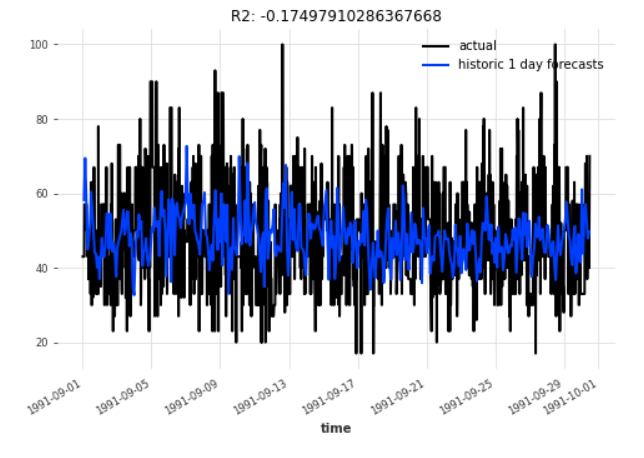

The results seems good enough. 

<a id="12"></a><h2></h2>
<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Way forward</center></h1>
</div>

1) Expand the model to include other 64 roads also

2) Hypertune the model

3) Include special values and rounding aspects

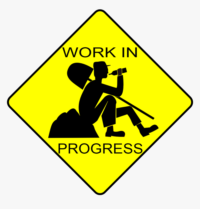

## References

https://www.kaggle.com/code/omershect/learning-pytorch-lstm-deep-learning-with-m5-data/notebook

https://www.kaggle.com/code/abdulravoofshaik/google-s-temporal-fusion-transformers/edit/run/89911411

https://unit8co.github.io/darts/README.html

https://arxiv.org/pdf/1905.10437.pdf

https://www.kaggle.com/code/martynovandrey/tps-mar-22-fe-model-selection

https://www.kaggle.com/code/ambrosm/tpsmar22-don-t-forget-to-round

https://www.kaggle.com/code/lonnieqin/tps-22-03-with-lstm

https://www.kaggle.com/ambrosm/tpsmar22-eda-which-makes-sense

https://www.kaggle.com/chaudharypriyanshu/febtabular-eda-fast-baseline

https://arxiv.org/pdf/1912.09363.pdf

https://www.kaggle.com/sytuannguyen/tps-mar-2022-eda-model

https://www.kaggle.com/martynovandrey/tps-mar-22-multioutput-cat-modeless

https://www.kaggle.com/luisblanche/pytorch-forecasting-temporalfusiontransformer

https://www.kaggle.com/shreyasajal/pytorch-forecasting-for-time-series-forecasting

https://www.kaggle.com/code/kotrying/tps-2022-03-lgbm

https://bulatov.page/bitcoin-nbeats

